In [41]:
import torch
from torch import (optim, nn)

from torch.utils.data import (
    DataLoader,
    TensorDataset,
    random_split
)

import numpy as np

# User-defined classes
from utils.base import (
    LinearRegression,
    Trainer
)

# Plotting
import matplotlib.pyplot as plt

plt.style.use("seaborn-v0_8")
plt.rcParams["font.family"] = "monospace"

In [6]:
# Constants
DEVICE = torch.device("cuda" if torch.cuda.is_available() else "cpu")
DTYPE = torch.float32
BATCH_SIZE = 32
NUM_EPOCHS = 50
SIZE = 200
GENERATOR = torch.Generator().manual_seed(42)

print(f"Device has ben set to: {torch.cuda.get_device_properties(DEVICE).name}")

Device has ben set to: NVIDIA GeForce GTX 1650


In [7]:
X = torch.randn(SIZE, 2, dtype=DTYPE, device='cpu')
y = 2 * X[:, 0] + 3 * X[:, 1] + 5 + torch.randn(SIZE, dtype=DTYPE, device='cpu')

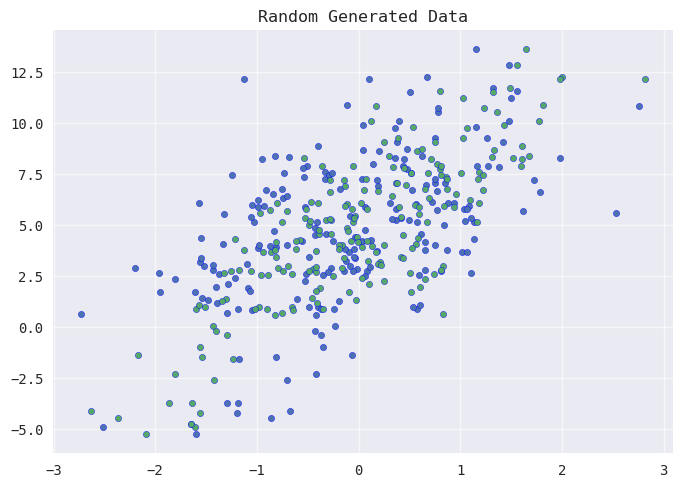

In [40]:
plt.scatter(X[:, 0].numpy(), y.numpy(), s=20, edgecolors="b");
plt.scatter(X[:, 1].numpy(), y.numpy(), s=20, edgecolors="b");
plt.grid(True, alpha = .6);
plt.title("Random Generated Data");
plt.show()

In [8]:
X, X.shape

(tensor([[ 1.4846,  1.5620],
         [-1.8019,  0.6580],
         [-0.5116,  1.5951],
         [ 0.6180, -0.3935],
         [ 0.8534,  0.3671],
         [ 0.1807, -0.4184],
         [-0.1102,  1.8188],
         [ 1.1318, -0.0539],
         [-1.0251,  1.1667],
         [-1.5186,  0.8275],
         [-0.0828, -0.0323],
         [ 0.6267,  0.3029],
         [-1.0470,  0.5597],
         [-1.1900, -1.8666],
         [ 0.5274,  0.0494],
         [-0.4840,  0.4130],
         [ 0.0642,  0.5972],
         [-0.9933,  1.0986],
         [ 0.0399,  1.3315],
         [ 0.6546, -0.8121],
         [-1.4803, -0.0266],
         [-0.6009, -1.3020],
         [-1.1728, -1.2387],
         [ 1.7816, -0.2809],
         [-2.5168, -1.6086],
         [ 1.4221,  0.2515],
         [ 0.0827, -1.2597],
         [ 1.1061, -0.5235],
         [-1.3375,  0.5608],
         [-0.0940,  0.1709],
         [ 1.9813, -0.5343],
         [ 0.7830,  1.3659],
         [-0.3270,  1.1833],
         [-0.0149, -0.4441],
         [-0.1

In [9]:
y, y.shape

(tensor([12.8448,  2.3675,  7.8809,  4.5520,  7.0637,  3.7360, 10.8599,  5.1187,
          5.1563,  2.9943,  5.4329,  8.3534,  5.9788, -3.7266,  6.7097,  3.4392,
          5.8848,  6.2083,  8.6756,  4.1586,  1.3244,  1.3821, -1.5872,  6.6032,
         -4.8827,  9.0375,  2.7368,  5.3165,  4.0397,  3.6668,  8.2889, 10.5359,
          7.5723,  2.8416,  1.2952,  5.7866,  3.8438,  0.8996,  3.8321,  2.9109,
          2.3759,  5.9990,  1.7100, -4.1149, -0.9657,  6.5316,  4.8429,  3.3702,
          0.6409,  7.0468,  3.6465, 12.2247,  0.9930,  2.7169,  9.8871,  3.1804,
          3.2197,  8.8623,  1.9205,  1.7476, 11.6930,  5.2358,  4.7419,  5.3169,
          6.7283,  0.9675,  5.1513,  9.0741, 10.0653,  3.3937, 12.1216,  5.2250,
          6.9476,  8.6009,  0.8524,  4.2403,  6.9174, 11.2007,  5.1362, -1.4543,
          5.9015,  6.0876,  4.4914,  5.9098, -2.6099,  8.6996,  4.9955,  0.8847,
         11.5004,  2.7604,  7.5447,  2.7390,  6.0795, -2.2801,  4.4121,  2.6149,
         11.5341, -4.2327,  

In [13]:
Data = TensorDataset(X, y)
Data.tensors

(tensor([[ 1.4846,  1.5620],
         [-1.8019,  0.6580],
         [-0.5116,  1.5951],
         [ 0.6180, -0.3935],
         [ 0.8534,  0.3671],
         [ 0.1807, -0.4184],
         [-0.1102,  1.8188],
         [ 1.1318, -0.0539],
         [-1.0251,  1.1667],
         [-1.5186,  0.8275],
         [-0.0828, -0.0323],
         [ 0.6267,  0.3029],
         [-1.0470,  0.5597],
         [-1.1900, -1.8666],
         [ 0.5274,  0.0494],
         [-0.4840,  0.4130],
         [ 0.0642,  0.5972],
         [-0.9933,  1.0986],
         [ 0.0399,  1.3315],
         [ 0.6546, -0.8121],
         [-1.4803, -0.0266],
         [-0.6009, -1.3020],
         [-1.1728, -1.2387],
         [ 1.7816, -0.2809],
         [-2.5168, -1.6086],
         [ 1.4221,  0.2515],
         [ 0.0827, -1.2597],
         [ 1.1061, -0.5235],
         [-1.3375,  0.5608],
         [-0.0940,  0.1709],
         [ 1.9813, -0.5343],
         [ 0.7830,  1.3659],
         [-0.3270,  1.1833],
         [-0.0149, -0.4441],
         [-0.1

In [17]:
Model = LinearRegression(in_dims=2).to(DEVICE)

In [18]:
trainData, valData = random_split(Data, (0.8, 0.2), generator=GENERATOR)

trainLoader = DataLoader(trainData, batch_size=BATCH_SIZE, shuffle=True)
valLoader = DataLoader(valData, batch_size=BATCH_SIZE, shuffle=True)

In [37]:
trainer = Trainer(
    Model,
    trainLoader,
    valLoader,
    optimizer=optim.SGD(Model.parameters(), lr=.1),
    criterion=nn.L1Loss(reduction='mean'),
    device=DEVICE
)

In [38]:
train_loss, val_loss = trainer.train(num_epochs=NUM_EPOCHS)

	Epoch 1 | Weights: tensor([-0.6331,  1.6712], device='cuda:0')
	Epoch 1 | Bias: tensor([0.1338], device='cuda:0')
	Epoch 1 | Weights: tensor([-0.6219,  1.6929], device='cuda:0')
	Epoch 1 | Bias: tensor([0.2150], device='cuda:0')
	Epoch 1 | Weights: tensor([-0.6121,  1.7113], device='cuda:0')
	Epoch 1 | Bias: tensor([0.3025], device='cuda:0')
	Epoch 1 | Weights: tensor([-0.6024,  1.7438], device='cuda:0')
	Epoch 1 | Bias: tensor([0.3838], device='cuda:0')
	Epoch 1 | Weights: tensor([-0.5697,  1.7370], device='cuda:0')
	Epoch 1 | Bias: tensor([0.4650], device='cuda:0')
Epoch 1/50 | Loss: 4.7132
	| Validation Loss: 4.5911

	Epoch 2 | Weights: tensor([-0.5498,  1.7359], device='cuda:0')
	Epoch 2 | Bias: tensor([0.5400], device='cuda:0')
	Epoch 2 | Weights: tensor([-0.5509,  1.7818], device='cuda:0')
	Epoch 2 | Bias: tensor([0.6213], device='cuda:0')
	Epoch 2 | Weights: tensor([-0.5327,  1.7895], device='cuda:0')
	Epoch 2 | Bias: tensor([0.7150], device='cuda:0')
	Epoch 2 | Weights: tensor

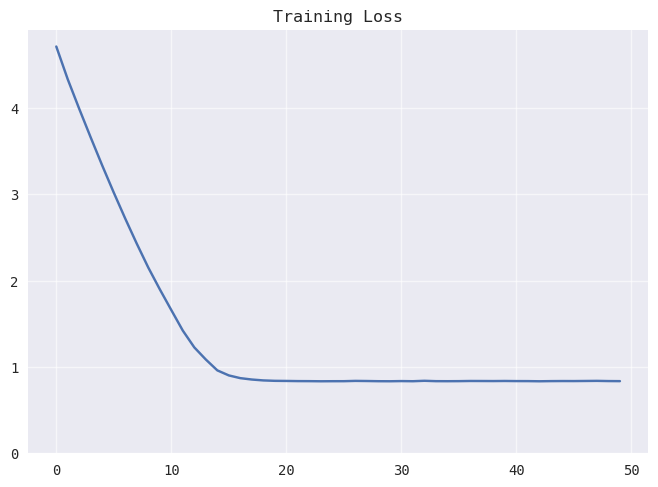

In [39]:
plt.plot(
    train_loss.keys(),
    train_loss.values()
);
plt.ylim(bottom=0)
plt.grid(True, alpha = .6);
plt.title("Training Loss");
plt.show()

In [42]:
# y = 2 * X[:, 0] + 3 * X[:, 1] + 5 + torch.randn(SIZE, dtype=DTYPE, device='cpu')
print(
    f"Trained Weights: {Model.w.data}",
    f"Trained Bias: {Model.b.data}",
    sep="\n"
)

Trained Weights: tensor([1.9296, 3.1209], device='cuda:0')
Trained Bias: tensor([4.9213], device='cuda:0')


In [43]:
T = np.linspace(X.min(), X.max(), SIZE, dtype=np.float32).reshape(SIZE, 1)
T = torch.tensor(np.concatenate([T, T], axis=1), device=DEVICE)

# Inference
with torch.no_grad():
    yT = Model(T)

print(f"\nGenerated T:\n{T}")
print(f"\nPredictions:\n{yT}")


Generated T:
tensor([[-2.7265, -2.7265],
        [-2.6987, -2.6987],
        [-2.6708, -2.6708],
        [-2.6429, -2.6429],
        [-2.6151, -2.6151],
        [-2.5872, -2.5872],
        [-2.5594, -2.5594],
        [-2.5315, -2.5315],
        [-2.5036, -2.5036],
        [-2.4758, -2.4758],
        [-2.4479, -2.4479],
        [-2.4200, -2.4200],
        [-2.3922, -2.3922],
        [-2.3643, -2.3643],
        [-2.3365, -2.3365],
        [-2.3086, -2.3086],
        [-2.2807, -2.2807],
        [-2.2529, -2.2529],
        [-2.2250, -2.2250],
        [-2.1971, -2.1971],
        [-2.1693, -2.1693],
        [-2.1414, -2.1414],
        [-2.1136, -2.1136],
        [-2.0857, -2.0857],
        [-2.0578, -2.0578],
        [-2.0300, -2.0300],
        [-2.0021, -2.0021],
        [-1.9742, -1.9742],
        [-1.9464, -1.9464],
        [-1.9185, -1.9185],
        [-1.8907, -1.8907],
        [-1.8628, -1.8628],
        [-1.8349, -1.8349],
        [-1.8071, -1.8071],
        [-1.7792, -1.7792],
      

In [44]:
T.shape, yT.shape

(torch.Size([200, 2]), torch.Size([200]))

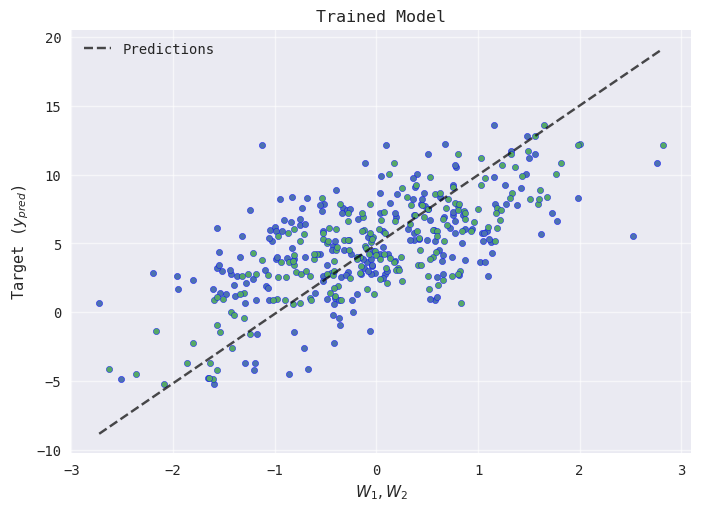

In [45]:
plt.scatter(X[:, 0].numpy(), y.numpy(), s=20, edgecolors="b");
plt.scatter(X[:, 1].numpy(), y.numpy(), s=20, edgecolors="b");
# Predicted Linear Model
plt.plot(T[:, 0].cpu().numpy(), yT.cpu().numpy(), color="black", alpha=.7, linestyle='--', label="Predictions");
plt.grid(True, alpha = .6);
plt.title("Trained Model");
plt.xlabel("$W_1, W_2$");
plt.ylabel("Target ($y_{pred}$)")
plt.legend(loc='best');
plt.show()